## Chapter 4 - Classifications - All graphs

The following notebook is a re-creation from
[JWarmenhoven's notebook](https://nbviewer.jupyter.org/github/JWarmenhoven/ISLR-python/tree/master/Notebooks/)
with the purpose of learning. However, some code blocks are changed to my understanding of the problem.

#### Import block

In [42]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing, neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

### Loading data set

In [43]:
# Note that I use 0 index instead of 1.
data_path = 'D:\\PycharmProjects\\ISLR\\data\\'
df = pd.read_excel(f'{data_path}Default.xlsx', usecols=list(range(1,5)))
# Transform the data into dummy
for i in ['default', 'student']:
    df[f'{i}2'] = df[i].astype('category').cat.codes
print('DEFAULT DATASET')
df.info()
df.head()

DEFAULT DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
default     10000 non-null object
student     10000 non-null object
balance     10000 non-null float64
income      10000 non-null float64
default2    10000 non-null int8
student2    10000 non-null int8
dtypes: float64(2), int8(2), object(2)
memory usage: 332.2+ KB


,default,student,balance,income,default2,student2
0,No,No,729.526495,44361.625074,0,0
1,No,Yes,817.180407,12106.134700,0,1
2,No,No,1073.549164,31767.138947,0,0
3,No,No,529.250605,35704.493935,0,0
4,No,No,785.655883,38463.495879,0,0


### Figure 4.1 - Default data set

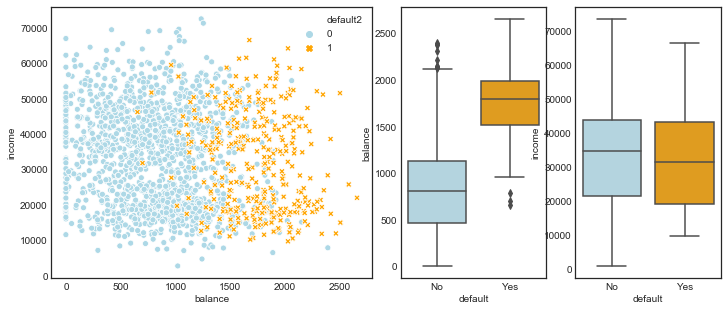

In [44]:
fig = plt.figure(figsize=(12,5))
gs = fig.add_gridspec(1,4)
ax1 = plt.subplot(gs[0,:2])
ax2 = plt.subplot(gs[0, 2])
ax3 = plt.subplot(gs[0, 3])

# Take a fraction of samples where target value (default) is 'no'
df_no = df[df.default2 == 0].sample(frac=0.15)
# Take all sample where target value is 'yes'
df_yes = df[df.default2 == 1]
df_ = df_no.append(df_yes)
df_.head()
c_palette = {0:'lightblue', 1:'orange'}
sns.scatterplot(x='balance', y='income', data=df_, ax=ax1, hue='default2', 
                style='default2', palette=c_palette)
d_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot(x='default', y='balance', data=df, orient='v', ax=ax2, palette=d_palette)
sns.boxplot(x='default', y='income', data=df, orient='v', ax=ax3, palette=d_palette)

## 4.3 Logistic Regression

### Figure 4.2

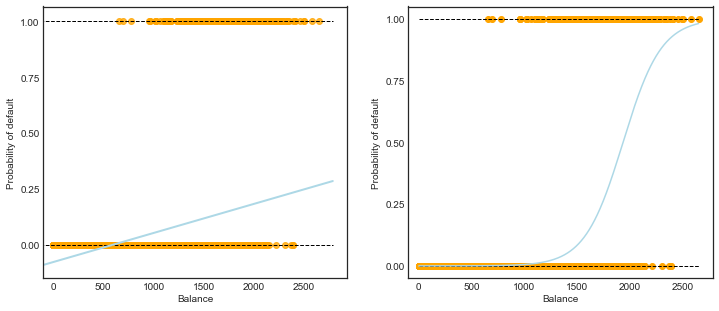

In [45]:
X_train = df.balance.values.reshape(-1,1)
y = df.default2

# Create array of test data. Calculate the classification probability and predicted classification
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train, y)
prob = clf.predict_proba(X_test)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# Left plot
sns.regplot(df.balance, df.default2, order=1, ci=None,
            scatter_kws={'color':'orange'}, line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Right plot
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_xlim(xmin=-100)

### Table 4.1

Using the newton-cg gives us the closest figures as in the books. For more comparison between
the solver please visit [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [46]:
clf = skl_lm.LogisticRegression(solver='newton-cg')
X_train = df.balance.values.reshape(-1,1)
y = df.default2
clf.fit(X_train, y)
print('classes:', clf.classes_)
print('coefficients:', clf.coef_)
print('intercept:', clf.intercept_)

classes: [0 1]
coefficients: [[0.00549891]]
intercept: [-10.65132506]


statsmodels - 2nd approaches

In [47]:
X_train = sm.add_constant(df.balance)
model = sm.Logit(y.ravel(), X_train)
model_fit = model.fit()
model_fit.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


d:\pycharmprojects\islr\venv\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.651331,0.361169,-29.491287,3.723665e-191,-11.359208,-9.943453
balance,0.005499,0.000220,24.952404,2.010855e-137,0.005067,0.005931


In [48]:
mod_fit = smf.logit('default2 ~ balance', data=df).fit()
mod_fit.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-10.651331,0.361169,-29.491287,3.723665e-191,-11.359208,-9.943453
balance,0.005499,0.000220,24.952404,2.010855e-137,0.005067,0.005931


### Table 4.2

In [49]:
model = smf.logit('default2 ~ student2', data=df)
model_fit = model.fit()
model_fit.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-3.504128,0.070713,-49.554094,0.000000,-3.642723,-3.365532
student2,0.404887,0.115019,3.520177,0.000431,0.179454,0.630320


### Table 4.3 - Multiple Logistic Regression

In [50]:
model = smf.logit('default2 ~ balance + income + student2', data=df)
model_fit = model.fit()
model_fit.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-10.869045,0.492273,-22.079320,4.995499e-108,-11.833882,-9.904209
balance,0.005737,0.000232,24.736506,4.331521e-135,0.005282,0.006191
income,0.000003,0.000008,0.369808,7.115254e-01,-0.000013,0.000019
student2,-0.646776,0.236257,-2.737595,6.189022e-03,-1.109831,-0.183721


### Figure 4.3 - Confounding

In [51]:
# balance and default vectors for students
df_student = df[df.student == 'Yes']

# balance and default vectors for non-students
df_non_student = df[df.student == 'No']

# Vector with balance values for plotting
X_test = np.arange(df.balance.min(), df.balance.max())
# X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

model_1 = smf.logit('default2 ~ balance', data=df_student)
model_2 = smf.logit('default2 ~ balance', data=df_non_student)

model_1_fit = model_1.fit()
model_2_fit = model_2.fit()

test_df = pd.DataFrame({'balance':X_test})
prob1 = model_1_fit.predict(test_df)
prob2 = model_2_fit.predict(test_df)

Optimization terminated successfully.
         Current function value: 0.095687
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.071433
         Iterations 10


In [52]:
df.groupby(['student', 'default']).size().unstack('default')

default,No,Yes
student,,
No,6850,206
Yes,2817,127


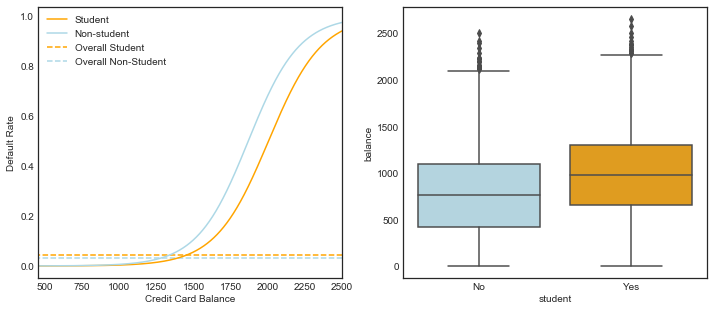

In [64]:
# Need to remember this line for later use
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.plot(X_test, prob1, color='orange', label='Student')
ax1.plot(X_test, prob2, color='lightblue', label='Non-student')
ax1.hlines(127/2817, colors='orange', label='Overall Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.hlines(206/6850, colors='lightblue', label='Overall Non-Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax1.set_xlim(450,2500)
ax1.legend(loc=2)

# Right plot
sns.boxplot(x='student', y='balance', data=df, orient='v', ax=ax2, palette=d_palette)

## 4.4 Linear Discriminant Analysis

### Table 4.4

In [66]:
X = df[['balance', 'income', 'student2']].as_matrix()
y = df.default2.as_matrix()

lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X,y).predict(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status', 'True default status']).size().unstack('True default status')

d:\pycharmprojects\islr\venv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
d:\pycharmprojects\islr\venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


True default status,No,Yes
Predicted default status,,
No,9645,254
Yes,22,79


In [67]:
print(classification_report(y, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.97      1.00      0.99      9667
         Yes       0.78      0.24      0.36       333

    accuracy                           0.97     10000
   macro avg       0.88      0.62      0.67     10000
weighted avg       0.97      0.97      0.97     10000



### Table 4.5
We are changing the decision boundary from 50% to 20% (Yes if > 20%) to get a better accuracy

In [74]:
decision_prob = 0.2
y_prob = lda.fit(X,y).predict_proba(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'False':'No', 'True':'Yes'}, inplace=True)
df_.groupby(['True default status', 'Predicted default status']).size().unstack('True default status')



True default status,No,Yes
Predicted default status,,
No,9435,140
Yes,232,193
